In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc
import seaborn as sns
%matplotlib inline

In [2]:
!ls -lhrt ../results/alignments

total 1680
drwxr-xr-x@ 2 jmorton  1396    64B Feb  2 14:38 attn
drwxr-xr-x@ 2 jmorton  1396    64B Feb  2 14:38 elmo
-rw-r--r--@ 1 jmorton  1396   418K Feb  3 16:06 elmo_5_alignment_scores.txt
-rw-r--r--@ 1 jmorton  1396   418K Feb  3 16:06 attn_uniref90_alignment_scores.txt
drwxr-xr-x@ 5 jmorton  1396   160B Feb  3 17:53 blast


In [3]:
!ls ../results/alignments/blast

blast_alignment_scores.txt swissprot_alignments.txt
scop_alignments.txt


In [4]:
results_dir = '../results/alignments'
attn_fname = f'{results_dir}/attn_uniref90_alignment_scores.txt'
elmo_fname = f'{results_dir}/elmo_5_alignment_scores.txt'
blast_fname = f'{results_dir}/blast/blast_alignment_scores.txt'

attn_df = pd.read_table(attn_fname, header=None)
elmo_df = pd.read_table(elmo_fname, header=None)
blast_df = pd.read_table(blast_fname, header=None)
domains = pd.read_csv('../data/domains/swissprot-pfam-domains.csv', skiprows=1, header=None)
domains.columns = ['protein', 'domain', 'source', 'domain_id', 'start', 'end']

# Only consider a subset of sequences

In [5]:
print(blast_df.shape, attn_df.shape, elmo_df.shape)

(15821, 4) (17647, 5) (17707, 5)


In [6]:
blast_df = blast_df.set_index([0, 1])
attn_df = attn_df.set_index([0, 1])
elmo_df = elmo_df.set_index([0, 1])

In [7]:
idx = list(set(attn_df.index) & set(elmo_df.index) & set(blast_df.index))

In [8]:
blast_df = blast_df.loc[idx]
elmo_df = elmo_df.loc[idx]
attn_df = attn_df.loc[idx]

blast_df = blast_df.loc[~blast_df.index.duplicated(keep='first')]
attn_df = attn_df.loc[~attn_df.index.duplicated(keep='first')]
elmo_df = elmo_df.loc[~elmo_df.index.duplicated(keep='first')]

In [9]:
print(blast_df.shape, attn_df.shape, elmo_df.shape)

(7481, 2) (7481, 3) (7481, 3)


In [10]:
blast_df[4] = attn_df[4]

In [11]:
attn_df['TPR'] = attn_df[2] / attn_df[4]
attn_df['FPR'] = attn_df[3] / attn_df[4]

elmo_df['TPR'] = elmo_df[2] / elmo_df[4]
elmo_df['FPR'] = elmo_df[3] / elmo_df[4]

blast_df['TPR'] = blast_df[2] / blast_df[4]
blast_df['FPR'] = blast_df[3] / blast_df[4]

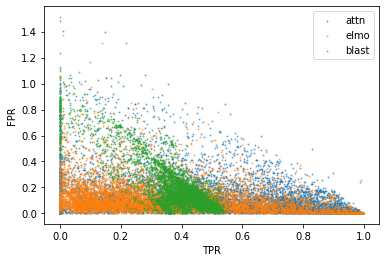

In [12]:
plt.scatter(attn_df['TPR'], attn_df['FPR'], label='attn', s=1, alpha=0.5)
plt.scatter(elmo_df['TPR'], elmo_df['FPR'], label='elmo', s=1, alpha=0.5)
plt.scatter(blast_df['TPR'], blast_df['FPR'], label='blast', s=1, alpha=0.5)

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.legend()

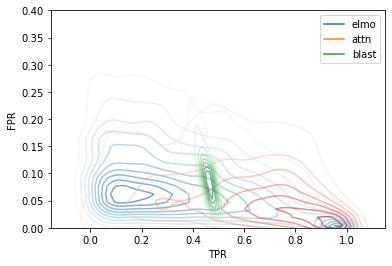

In [13]:
sns.kdeplot(elmo_df['TPR'], elmo_df['FPR'], cmap="Blues", label='elmo', alpha=0.5)
sns.kdeplot(attn_df['TPR'], attn_df['FPR'], cmap="Reds", label='attn', alpha=0.5)
sns.kdeplot(blast_df['TPR'], blast_df['FPR'], cmap="Greens", label='blast', alpha=0.5)

plt.ylim([0, 0.4])
plt.legend()

In [14]:
elmo_df['PPV'] = elmo_df['TPR'] / (elmo_df['TPR'] + elmo_df['FPR'])
attn_df['PPV'] = attn_df['TPR'] / (attn_df['TPR'] + attn_df['FPR'])
blast_df['PPV'] = blast_df['TPR'] / (blast_df['TPR'] + blast_df['FPR'])

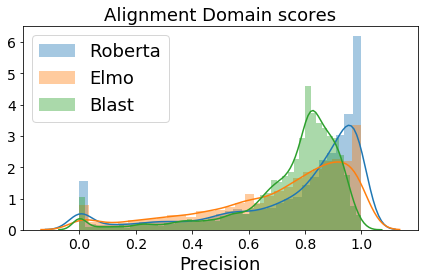

In [51]:
sns.distplot(attn_df['PPV'].dropna(), label='Roberta')
sns.distplot(elmo_df['PPV'].dropna(), label='Elmo')
sns.distplot(blast_df['PPV'].dropna(), label='Blast')
plt.xlabel('Precision', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Alignment Domain scores', fontsize=18)
plt.tight_layout()
plt.savefig('../figures/alignment_precision.pdf')

In [26]:
from scipy.stats import sem
print(np.mean(attn_df['PPV'].dropna()), sem(attn_df['PPV'].dropna()))
print(np.mean(elmo_df['PPV'].dropna()), sem(elmo_df['PPV'].dropna()))
print(np.mean(blast_df['PPV'].dropna()), sem(blast_df['PPV'].dropna()))

0.753920990156988 0.003192463465003214
0.7007147730148333 0.0030207636200011833
0.7427248923485658 0.002374643186645569


In [27]:
col='TPR'
print(np.mean(attn_df[col].dropna()), sem(attn_df[col].dropna()))
print(np.mean(elmo_df[col].dropna()), sem(elmo_df[col].dropna()))
print(np.mean(blast_df[col].dropna()), sem(blast_df[col].dropna()))

0.5217635983860842 0.003370701225553931
0.37000303163785925 0.0030810778695899493
0.40596535676488527 0.0011695216159785958


In [28]:
col='FPR'
print(np.mean(attn_df[col].dropna()), sem(attn_df[col].dropna()))
print(np.mean(elmo_df[col].dropna()), sem(elmo_df[col].dropna()))
print(np.mean(blast_df[col].dropna()), sem(blast_df[col].dropna()))

0.133870499769938 0.001954142280832872
0.11226365525099503 0.0013396436087569432
0.1594698885820977 0.00189913208019231


In [33]:
elmo_df['FV'] = elmo_df['TPR'] / (elmo_df['FPR'])
attn_df['FV'] = attn_df['TPR'] / (attn_df['FPR'])
blast_df['FV'] = blast_df['TPR'] / (blast_df['FPR'])

0       1     
Q049W8  A4JCQ9     2.478261
B8IYH5  Q8TRU4     0.136986
Q9ZLB9  A4YHH3     0.675676
C1A6Q3  A6LPP6    11.137931
B0UUT7  Q03ZQ9    15.000000
                    ...    
Q2JMQ3  B9LSZ3     1.348837
Q0SQL7  B9L5Z7     9.900000
Q86KU6  A0Q0A0    10.090909
A6TXB7  B7MT77    21.250000
A5UDT0  B1AIN7     0.000000
Name: FV, Length: 6889, dtype: float64

In [44]:
col='FV'
print(np.mean(attn_df.loc[attn_df['FPR'] > 0, col]), sem(attn_df.loc[attn_df['FPR'] > 0, col]))
print(np.mean(elmo_df.loc[elmo_df['FPR'] > 0, col]), sem(elmo_df.loc[elmo_df['FPR'] > 0, col]))
print(np.mean(blast_df.loc[blast_df['FPR'] > 0, col]), sem(blast_df.loc[blast_df['FPR'] > 0, col]))

16.076305163032025 0.4380146870585288
9.34273451184182 0.2910260493075501
6.2830545177824675 0.15230170693358547


In [55]:
align_stats = pd.DataFrame(
    {
        'Roberta': [np.mean(attn_df.loc[attn_df['FPR'] > 0, col]), np.mean(attn_df['PPV'].dropna())],
        'Elmo': [np.mean(elmo_df.loc[elmo_df['FPR'] > 0, col]), np.mean(elmo_df['PPV'].dropna())],
        'Blast': [np.mean(blast_df.loc[blast_df['FPR'] > 0, col]), np.mean(blast_df['PPV'].dropna())]
    },
    index=['Positive Likelihood', 'Precision']
).T

In [56]:
print(align_stats.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Positive Likelihood &  Precision \\
\midrule
Roberta &            16.076305 &   0.753921 \\
Elmo    &             9.342735 &   0.700715 \\
Blast   &             6.283055 &   0.742725 \\
\bottomrule
\end{tabular}



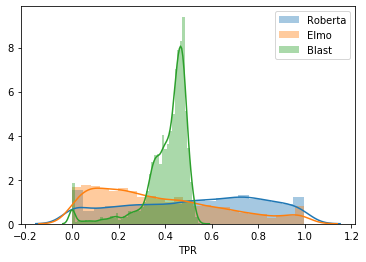

In [16]:
sns.distplot(attn_df['TPR'].dropna(), label='Roberta')
sns.distplot(elmo_df['TPR'].dropna(), label='Elmo')
sns.distplot(blast_df['TPR'].dropna(), label='Blast')

plt.legend()

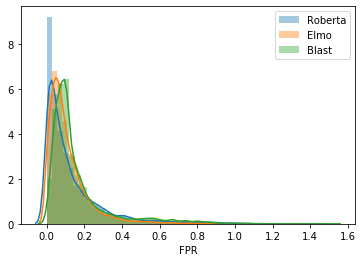

In [17]:
sns.distplot(attn_df['FPR'].dropna(), label='Roberta')
sns.distplot(elmo_df['FPR'].dropna(), label='Elmo')
sns.distplot(blast_df['FPR'].dropna(), label='Blast')

plt.legend()

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

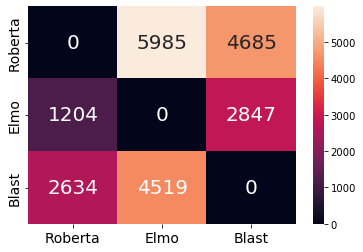

In [128]:
comp_df = pd.DataFrame([
    [0, np.sum(attn_df['TPR'] > elmo_df['TPR']), np.sum(attn_df['TPR'] > blast_df['TPR'])],
    [np.sum(elmo_df['TPR'] > attn_df['TPR']), 0, np.sum(elmo_df['TPR'] > blast_df['TPR'])],
    [np.sum(blast_df['TPR'] > attn_df['TPR']), np.sum(blast_df['TPR'] > elmo_df['TPR']), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)


(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

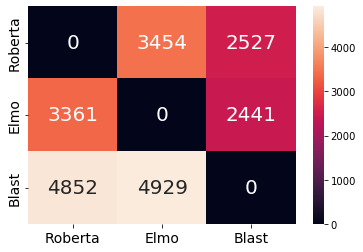

In [129]:
col = 'FPR'
comp_df = pd.DataFrame([
    [0, np.sum(attn_df[col] > elmo_df[col]), np.sum(attn_df[col] > blast_df[col])],
    [np.sum(elmo_df[col] > attn_df[col]), 0, np.sum(elmo_df[col] > blast_df[col])],
    [np.sum(blast_df[col] > attn_df[col]), np.sum(blast_df[col] > elmo_df[col]), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

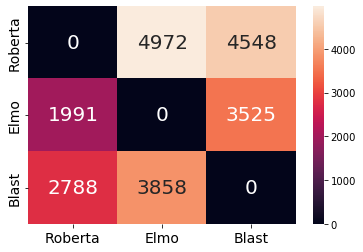

In [130]:
col = 'PPV'
comp_df = pd.DataFrame([
    [0, np.sum(attn_df[col] > elmo_df[col]), np.sum(attn_df[col] > blast_df[col])],
    [np.sum(elmo_df[col] > attn_df[col]), 0, np.sum(elmo_df[col] > blast_df[col])],
    [np.sum(blast_df[col] > attn_df[col]), np.sum(blast_df[col] > elmo_df[col]), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)

In [6]:
elmo_df = elmo_df.set_index([0, 1])
attn_df = attn_df.set_index([0, 1])

In [7]:
elmo_df = elmo_df.loc[attn_df.index]
attn_df = attn_df.loc[elmo_df.index]

/Users/jmorton/miniconda3/envs/gert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [8]:
tpr_diff = (attn_df[2] - elmo_df[2]).dropna()
fpr_diff = (attn_df[3] - elmo_df[3]).dropna()

In [9]:
np.sum(tpr_diff > 0), np.sum(tpr_diff < 0)

(1735, 2093)

In [10]:
np.sum(fpr_diff > 0), np.sum(fpr_diff < 0)

(1101, 2381)

In [17]:
tpr_diff.loc[tpr_diff<0].sort_values()

0       1     
Q2SY55  Q63RX6   -1488.0
Q8DGW9  Q5FHK5   -1101.0
Q1D0P7  Q4UTB0   -1099.0
Q605M0  Q2KYF3   -1085.0
B6I240  Q6BPD3    -977.0
                   ...  
Q8EEZ1  Q49V26      -1.0
Q8DQY0  Q1J4X1      -1.0
Q49XB7  Q8Z8B0      -1.0
A7FH54  B6I5H3      -1.0
Q2FXY1  Q0K6Y5      -1.0
Name: 2, Length: 2093, dtype: float64